In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
#reading CSV tables
admissions = pd.read_csv("./data/ADMISSIONS.csv")
patients = pd.read_csv("./data/PATIENTS.csv")
services = pd.read_csv("./data/SERVICES.csv")
icustays = pd.read_csv("./data/ICUSTAYS.csv")
drgcodes = pd.read_csv("./data/DRGCODES.csv")

In [3]:
#tables joins to data frame
df = admissions.join(patients.set_index("subject_id"), on = "subject_id", lsuffix="_adm", rsuffix="_pat")
df = df.join(services.set_index(["subject_id", "hadm_id"]), on = ["subject_id", "hadm_id"])
df = df.join(icustays.set_index(["subject_id", "hadm_id"]), on = ["subject_id", "hadm_id"], rsuffix="_icu")
df = df.join(drgcodes.set_index(["subject_id", "hadm_id"]), on = ["subject_id", "hadm_id"], rsuffix="_drg")

Kilka luźnych uwag do zanotowania:
- część zmiennych tworzy wiele rekordów do pojedynczego pobytu pacjenta (np. curr_service, te od kodów DRG), a df musi mieć formę: wiersz opisujący pobyt pacjenta - target 
- trzeba te zmienne zagregować albo z nich zrezygnować
- z tych powodów nie wziąłem np microbiology events
- zmiennych jest 15 więc spokojnie może coś odpaść przy EDA
- CSVki w folderze jak wyżej umieście i nie wrzucamy go na repo, jak będziemy mieli docelowy df to wtedy trzeba zapisać do CSV i na repo
- jak jakieś inne zmienne itp. to kodu wiele nie ma wiadomo co i gdzie możecie zmieniać

In [4]:
df = df[[
    #identyfikator pobytu pacjenta: subject_id + hadm_id
    "subject_id", "hadm_id",
    ###ADMISSIONS
    #czas przyjęcia, wypisu
    "admittime", "dischtime",
    #typ pobytu
    "admission_type",
    #dane personalne
    "insurance", "language", "religion", "marital_status", "ethnicity",
    #TARGET zmienna binarna śmierć w szpitalu
    "hospital_expire_flag",
    ###PATIENTS
    "gender", 
    #data urodzenia
    "dob",
    ###SERVICES
    #opieka/zabieg
    "curr_service",
    ###ICUSTAYS
    #długość pobytu na ICU
    "los",
    ###DRGCODES
    #para identyfikująca 
    "drg_type", "drg_code",
    "drg_severity", "drg_mortality",
]]

In [5]:
df

,subject_id,hadm_id,admittime,dischtime,admission_type,insurance,language,religion,marital_status,ethnicity,hospital_expire_flag,gender,dob,curr_service,los,drg_type,drg_code,drg_severity,drg_mortality
0,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,EMERGENCY,Medicare,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,0,F,2094-03-05 00:00:00,MED,1.6325,HCFA,416,NaN,NaN
1,10011,105331,2126-08-14 22:32:00,2126-08-28 18:59:00,EMERGENCY,Private,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,1,F,2090-06-05 00:00:00,MED,13.8507,HCFA,205,NaN,NaN
2,10013,165520,2125-10-04 23:36:00,2125-10-07 15:13:00,EMERGENCY,Medicare,NaN,CATHOLIC,NaN,UNKNOWN/NOT SPECIFIED,1,F,2038-09-03 00:00:00,MED,2.6499,HCFA,416,NaN,NaN
3,10017,199207,2149-05-26 17:19:00,2149-06-03 18:42:00,EMERGENCY,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,0,F,2075-09-21 00:00:00,MED,2.1436,APR,3153,3.0,3.0
3,10017,199207,2149-05-26 17:19:00,2149-06-03 18:42:00,EMERGENCY,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,0,F,2075-09-21 00:00:00,MED,2.1436,HCFA,491,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,44222,192189,2180-07-19 06:55:00,2180-07-20 13:00:00,EMERGENCY,Medicare,ENGL,CATHOLIC,SINGLE,WHITE,0,M,2107-06-27 00:00:00,CMED,1.3279,APR,2013,3.0,3.0
127,44222,192189,2180-07-19 06:55:00,2180-07-20 13:00:00,EMERGENCY,Medicare,ENGL,CATHOLIC,SINGLE,WHITE,0,M,2107-06-27 00:00:00,CMED,1.3279,MS,308,NaN,NaN
128,44228,103379,2170-12-15 03:14:00,2170-12-24 18:00:00,EMERGENCY,Private,ENGL,NOT SPECIFIED,SINGLE,WHITE,0,F,2112-10-22 00:00:00,SURG,4.6191,APR,7203,3.0,4.0
128,44228,103379,2170-12-15 03:14:00,2170-12-24 18:00:00,EMERGENCY,Private,ENGL,NOT SPECIFIED,SINGLE,WHITE,0,F,2112-10-22 00:00:00,SURG,4.6191,APR,7203,3.0,4.0


Zmienna celu to: hospital_expire_flag

W kolumnach language, religion, marital_status, drg_severity i drg_mortality mamy braki danych

In [6]:
# Dokonamy imputacji zmiennych kategorycznych
df['language'] = df['language'].fillna('Missing_language')
df['religion'] = df['religion'].fillna('Missing_religion') 
df['marital_status'] = df['marital_status'].fillna('Missing_marital_status') 

In [7]:
# Dokonamy imputacji zmiennych ciągłych
df.drg_severity.fillna(df.drg_severity.median(), inplace=True)
df.drg_mortality.fillna(df.drg_mortality.median(), inplace=True)

In [8]:
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore') # u mnie bez tego daje warning

columns_to_encode = ['language', 'religion', 'marital_status', 'drg_severity', 'drg_mortality']

enc = OneHotEncoder(handle_unknown='ignore')
enc_df = pd.DataFrame(
    enc.fit_transform(df[columns_to_encode]).toarray(),
    columns = enc.get_feature_names(input_features = columns_to_encode)
)

enc_df = df.join(enc_df).drop(columns_to_encode, axis = 1)


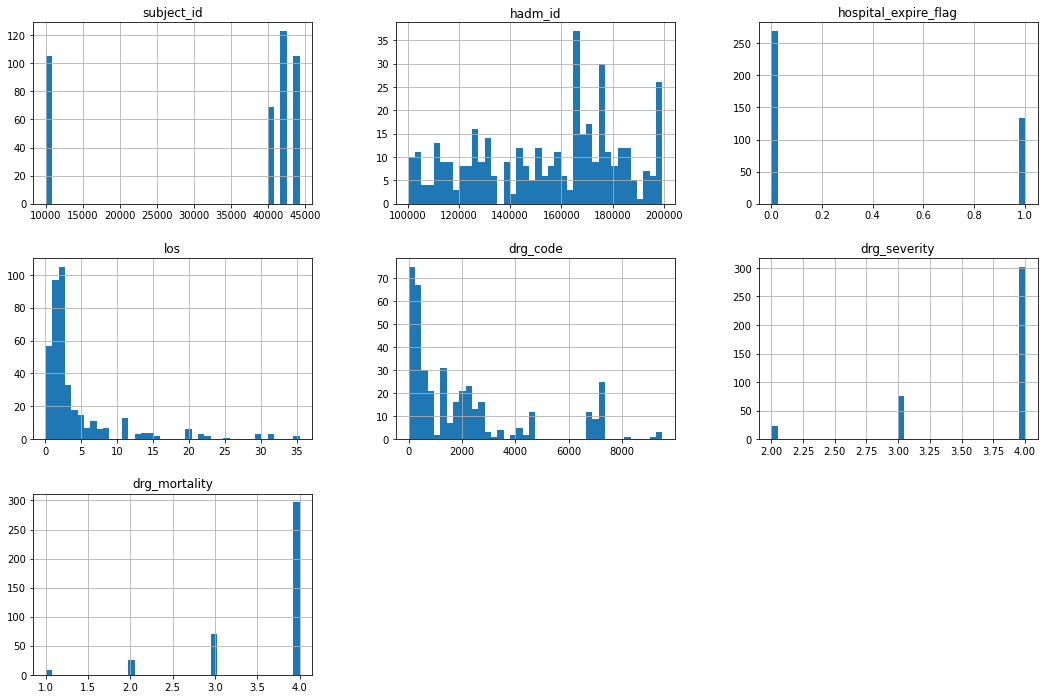

In [9]:
df.hist(bins = 40, figsize=(18, 12))

plt.show()

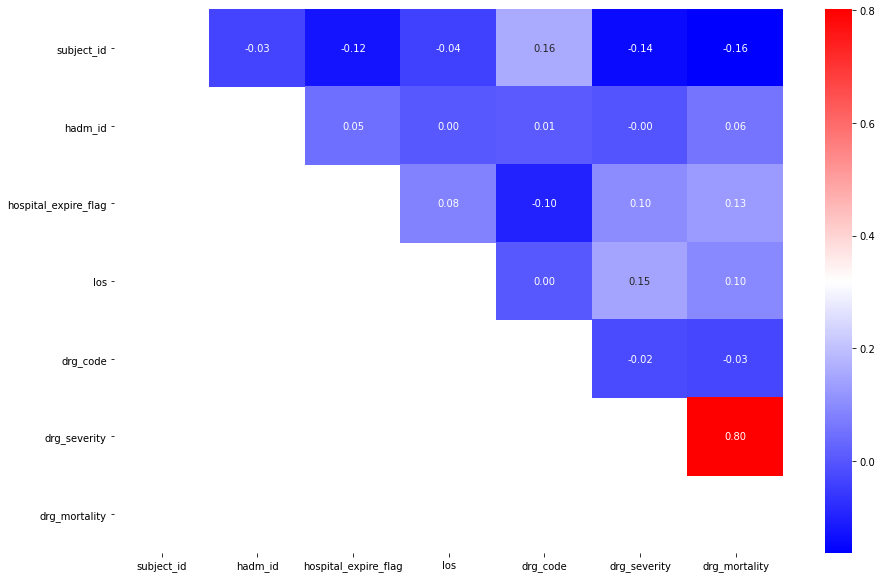

In [13]:
df_corr = df.corr()
mask = np.triu(np.ones_like(df_corr, dtype=bool)).transpose()

plt.subplots(figsize=(15,10))
sns.heatmap(df_corr, mask = mask, cmap = 'bwr', annot=True, fmt='.2f')
plt.show()

* drg_severity jest dodatnio skorelowany z drg_mortality

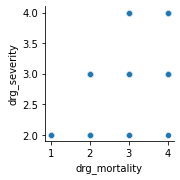

In [17]:
# Zobaczymy odkryte zależności na wykresach punktowych

sns.pairplot(df, y_vars="drg_severity", x_vars="drg_mortality")
plt.show()

Korelacji nie za bardzo widać na rysunku